In [1]:
library(ggplot2)
library(Seurat)
library(plyr)
library(dplyr)
library(Matrix)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# First pass clustering analysis

Here we will do an initial QC analysis and clustering of the data

In [2]:
aggr.data <- Read10X("IR_CR6_no_norm/filtered_feature_bc_matrix")

genes.seurat <- CreateSeuratObject(aggr.data, min.cells = 10, min.features = 200, project = "IR")
dim(genes.seurat)
remove(aggr.data)

genes.seurat[["percent.mt"]] <- PercentageFeatureSet(genes.seurat, pattern = "^mt-")

cellSample <- sub(".*-(.*)","\\1", colnames(genes.seurat))
cellSample <- plyr::mapvalues(cellSample, 
                              from = as.character(seq(1, 6)),
                              to = c("Sham_1", "Sham_2", "Sham_3",
                                     "IR_1", "IR_3", "IR_4"))

names(cellSample) = colnames(genes.seurat)
table(cellSample)
genes.seurat <- AddMetaData(genes.seurat, cellSample, col.name = "Experiment")

[1] 19266 56305

cellSample
  IR_1   IR_3   IR_4 Sham_1 Sham_2 Sham_3 
  9845   9022   9007   9676  13012   5743 

Generate some QC metrics

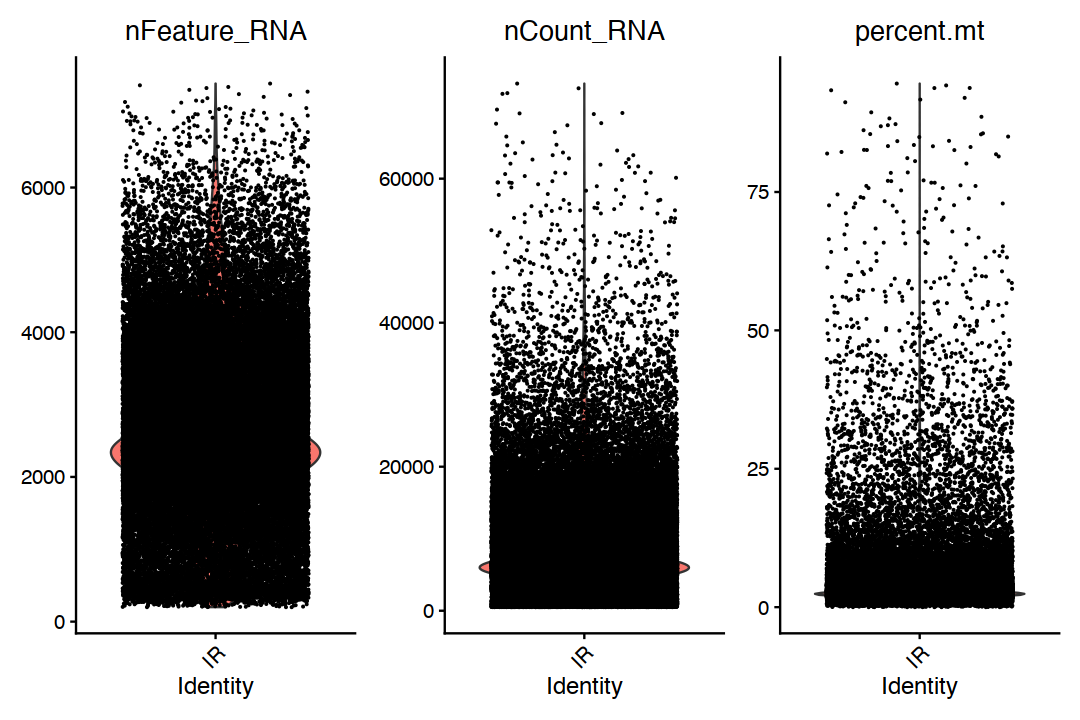

In [3]:
#Violin plot of QC metrics
options(repr.plot.width=9, repr.plot.height=6)
VlnPlot(genes.seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

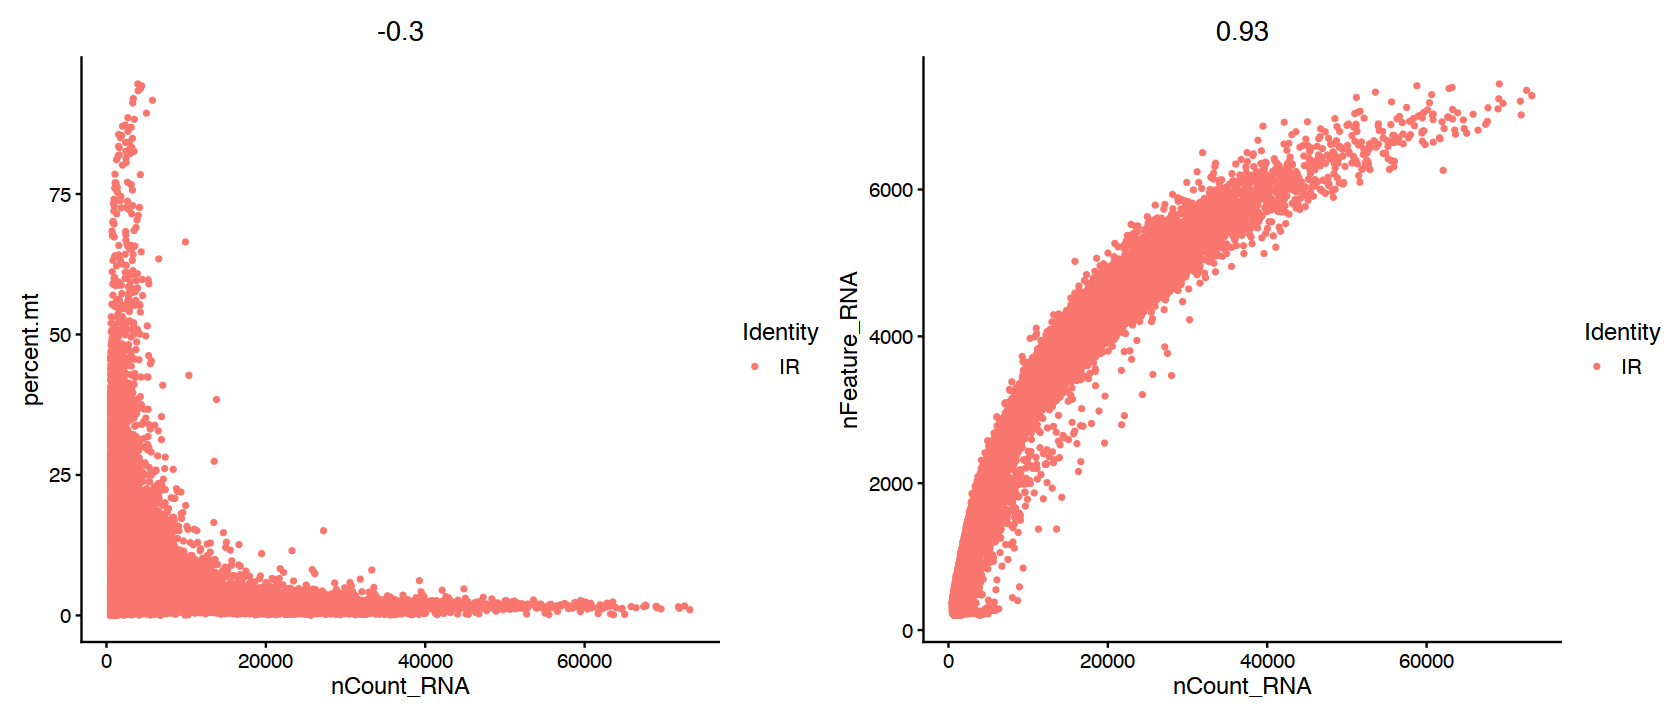

In [4]:
options(repr.plot.width=14, repr.plot.height=6)
plot1 <- FeatureScatter(genes.seurat, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(genes.seurat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

Filter out outliers and run clustering

[1] 19266 51750

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”
Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Regressing out nCount_RNA, Experiment

Centering and scaling data matrix

PC_ 1 
Positive:  Ccna2, Tpx2, Top2a, Birc5, Mki67, Pbk, Prc1, Cdca8, Cenpf, Cdca3 
	   Pclaf, Spc25, Ube2c, Hmmr, Kif23, Ccnb1, Cdc20, Tk1, Pimreg, Mxd3 
	   Spc24, Racgap1, Plk1, Nuf2, Cenpe, Ckap2l, Nusap1, Stmn1, Kif22, Ckap2 
Negative:  Col1a2, Col1a1, Col3a1, Ogn, Sfrp1, Mfap4, Cst3, Col14a1, Cthrc1, Sfrp2 
	   Sparc, Col5a2, Gxylt2, Meg3, Mmp23, Mfap2, Fn1, Col5a1, Lox, Pdgfrl 
	   Gas6, Thbs2, Itgbl1, Ptn, Rbp1, Cpxm1, Eln, Rcn3, Itm2a, Fstl1 
PC_ 2 
Positive:  Gpm6a, Nkain4, Upk3b, Lrrn4, Gm49708, Krt19, Upk1b, Msln, Lgals7, Pkhd1l1 
	   Dmkn, Lsr, Krt18, Wt1, Slc9a3r1, Ptgs1, Krt8, Cxadr, Tmem151a, Smpd3 
	   Spint2, Krt7, Rsp

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 51750
Number of edges: 1546039

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9140
Number of communities: 20
Elapsed time: 11 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 51750
Number of edges: 1546039

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8981
Number of communities: 24
Elapsed time: 10 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 51750
Number of edges: 1546039

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8833
Number of communities: 27
Elapsed time: 10 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 51750
Number of edges: 1546039

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8711
Number of communities: 31
Elapsed time: 11 seconds
Modu

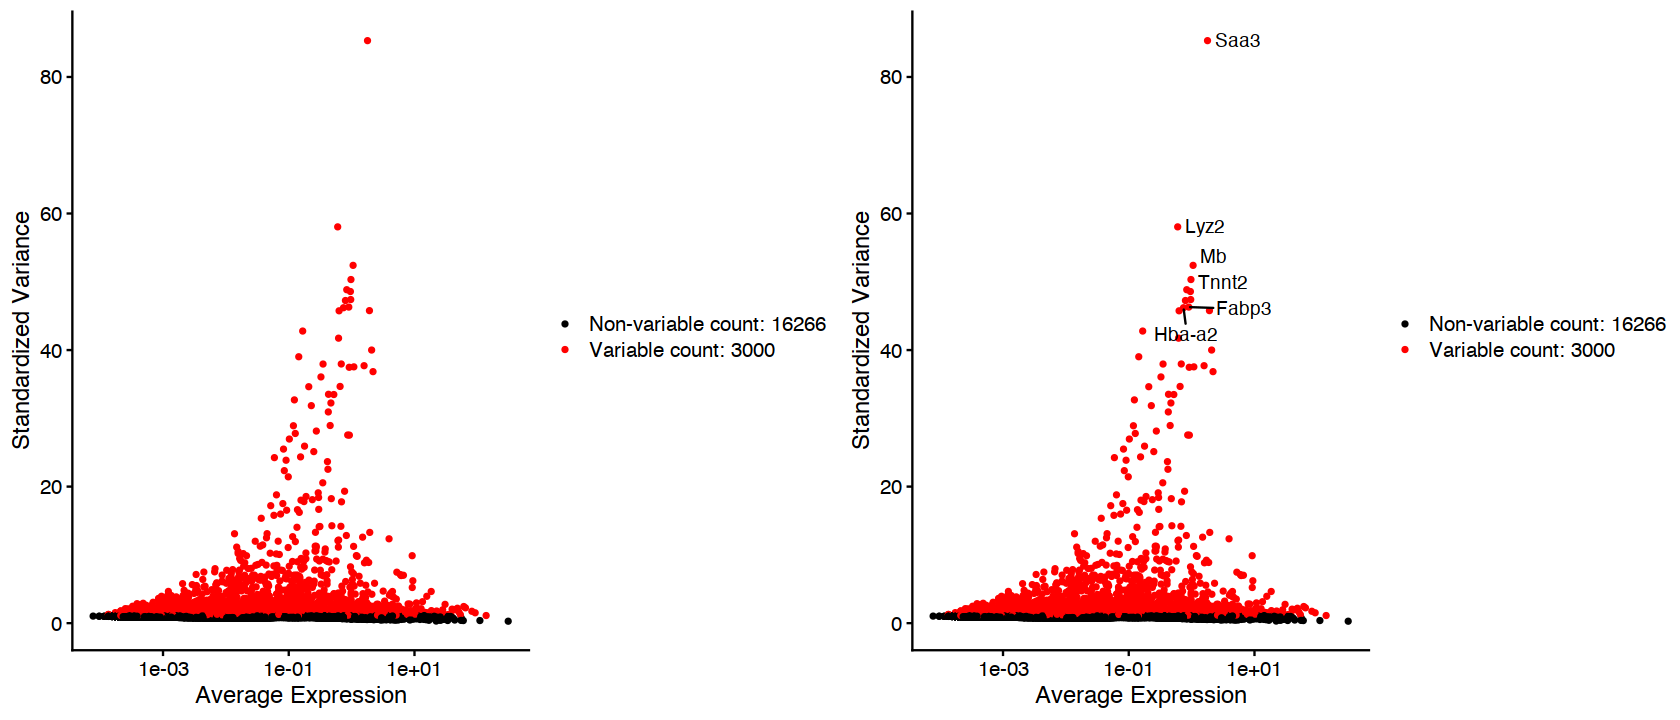

In [5]:
genes.seurat <- subset(genes.seurat, subset = nFeature_RNA > 200 & nFeature_RNA < 6000 & percent.mt < 10 &
                         nCount_RNA > 500 & nCount_RNA < 40000)
dim(genes.seurat)

# Normalise data
genes.seurat <- NormalizeData(object = genes.seurat, 
                              normalization.method = "LogNormalize", 
                              scale.factor = 10000)

# Find higly variable genes
genes.seurat <- FindVariableFeatures(object = genes.seurat, mean.function = "vst", nfeatures = 3000)
top10 <- head(VariableFeatures(genes.seurat), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(genes.seurat)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
CombinePlots(plots = list(plot1, plot2))

# Regress of unwanted variation
genes.seurat <- ScaleData(genes.seurat, 
                          vars.to.regress = c("nCount_RNA", "Experiment"), 
                          verbose = TRUE)

genes.seurat <- RunPCA(object = genes.seurat, features = VariableFeatures(object = genes.seurat), npcs=60)
#genes.seurat <- RunPCA(object = genes.seurat)

## Clustering
genes.seurat <- FindNeighbors(genes.seurat, dims = 1:25)
genes.seurat <- FindClusters(genes.seurat, resolution = seq(0.4, 1.2, 0.2))

Idents(genes.seurat) <- genes.seurat@meta.data$RNA_snn_res.0.6

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
17:51:40 UMAP embedding parameters a = 0.9922 b = 1.112

17:51:40 Read 51750 rows and found 25 numeric columns

17:51:40 Using Annoy for neighbor search, n_neighbors = 30

17:51:40 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:51:43 Writing NN index file to temp file /var/folders/2p/fzztw4ls58lcjyzm918ky5900000gn/T//RtmpD03Lzy/filecd2c2a366062

17:51:43 Searching Annoy index using 1 thread, search_k = 3000

17:51:56 Annoy recall = 100%

17:51:56 Commencing smooth kNN distance calibra

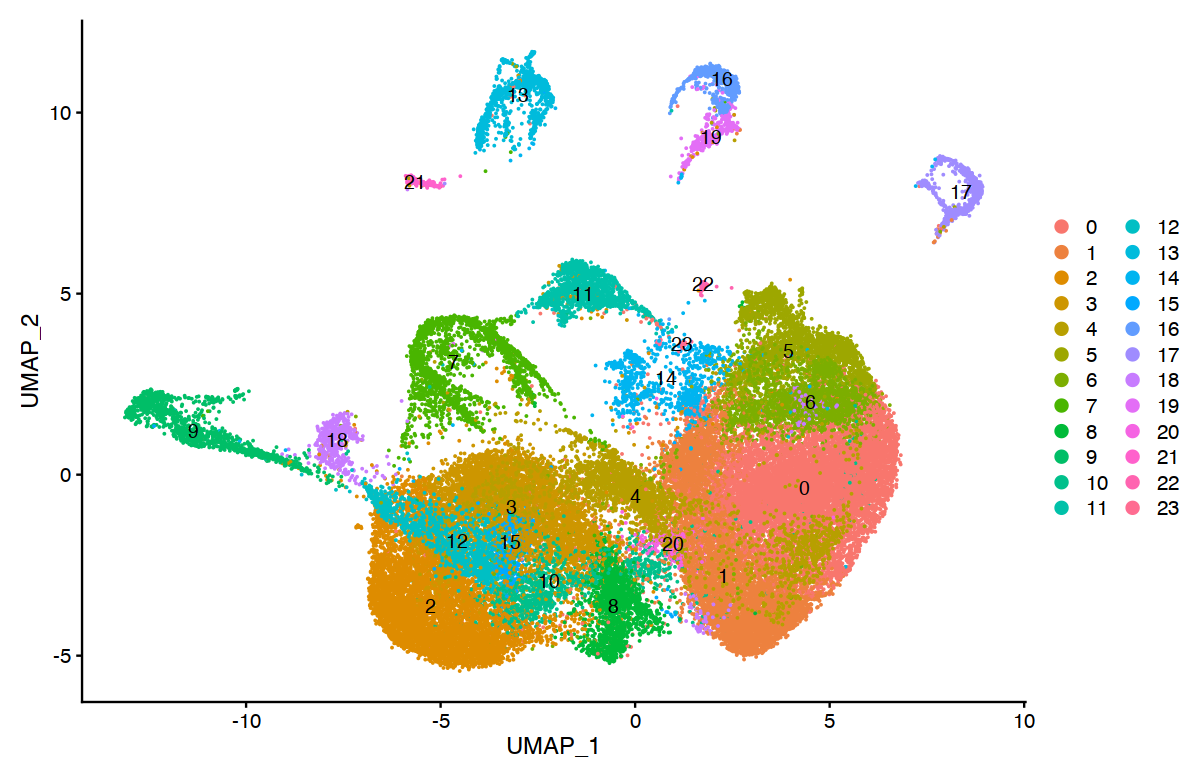

In [6]:
genes.seurat <- RunUMAP(genes.seurat, dims = 1:25)

options(repr.plot.width=10, repr.plot.height=6.5) 
DimPlot(genes.seurat, reduction = "umap", label = TRUE)

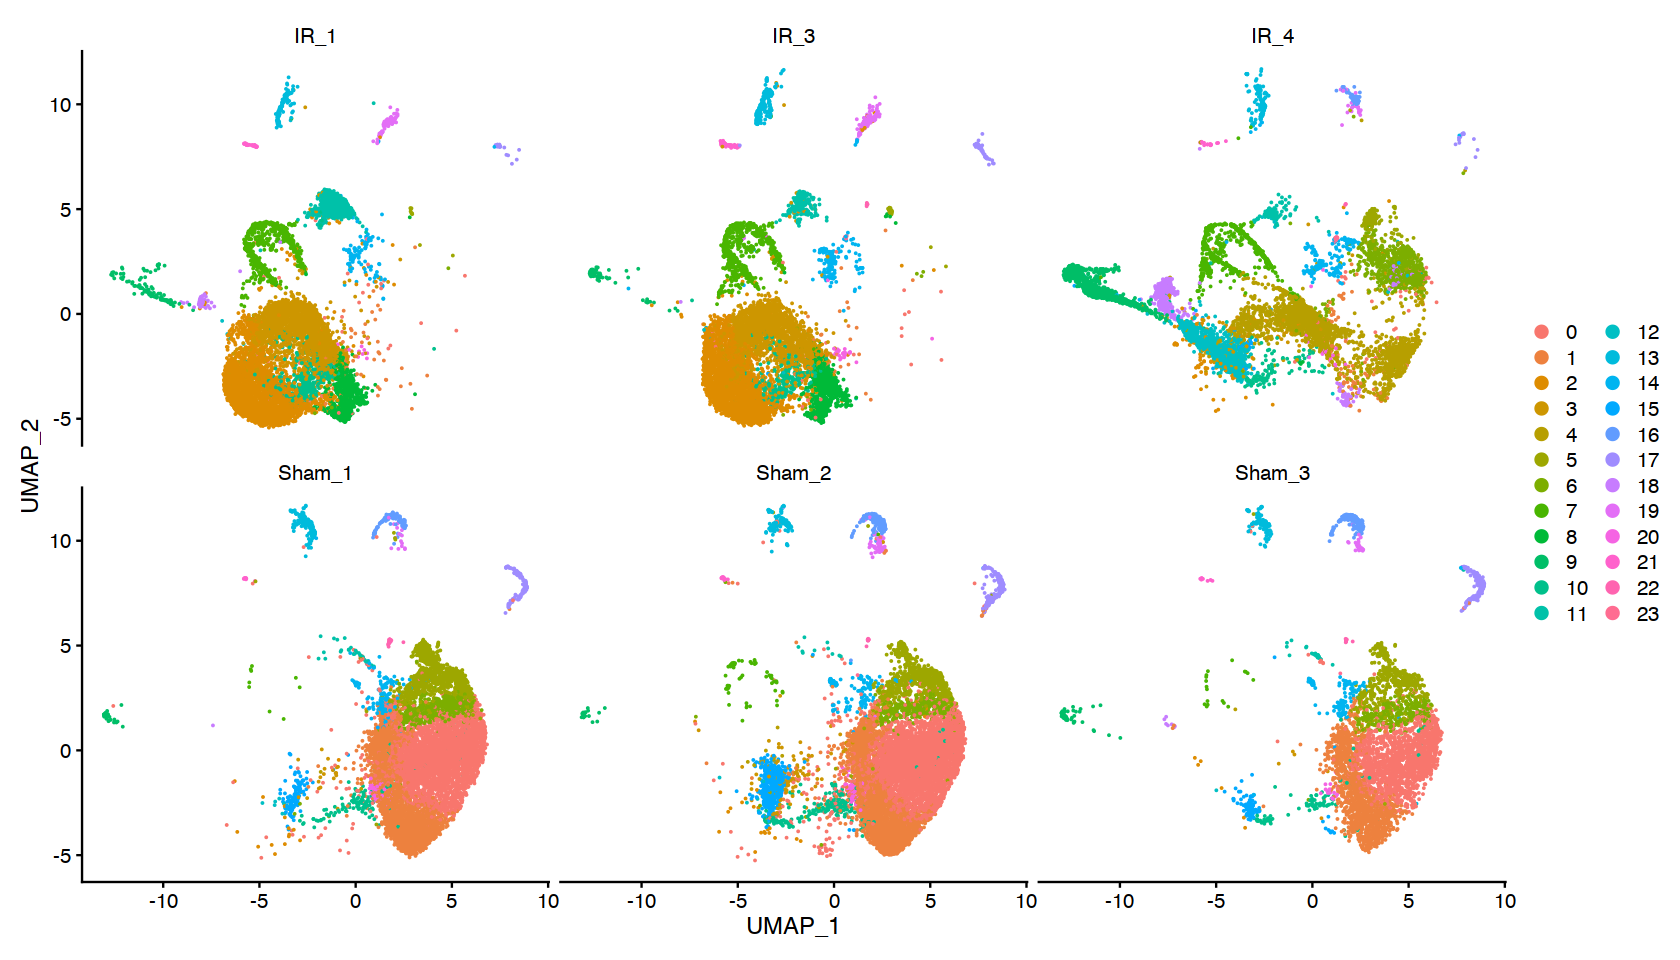

In [7]:
options(repr.plot.width=14, repr.plot.height=8) 
DimPlot(genes.seurat, reduction = "umap", split.by = "Experiment", ncol = 3)

# Doublet filtering

Visualise and filter doublets identified with Scrublet

[1] "Predicted singlets from Scrublet: 55589"
[1] "Overlap with filtered data: 50987"


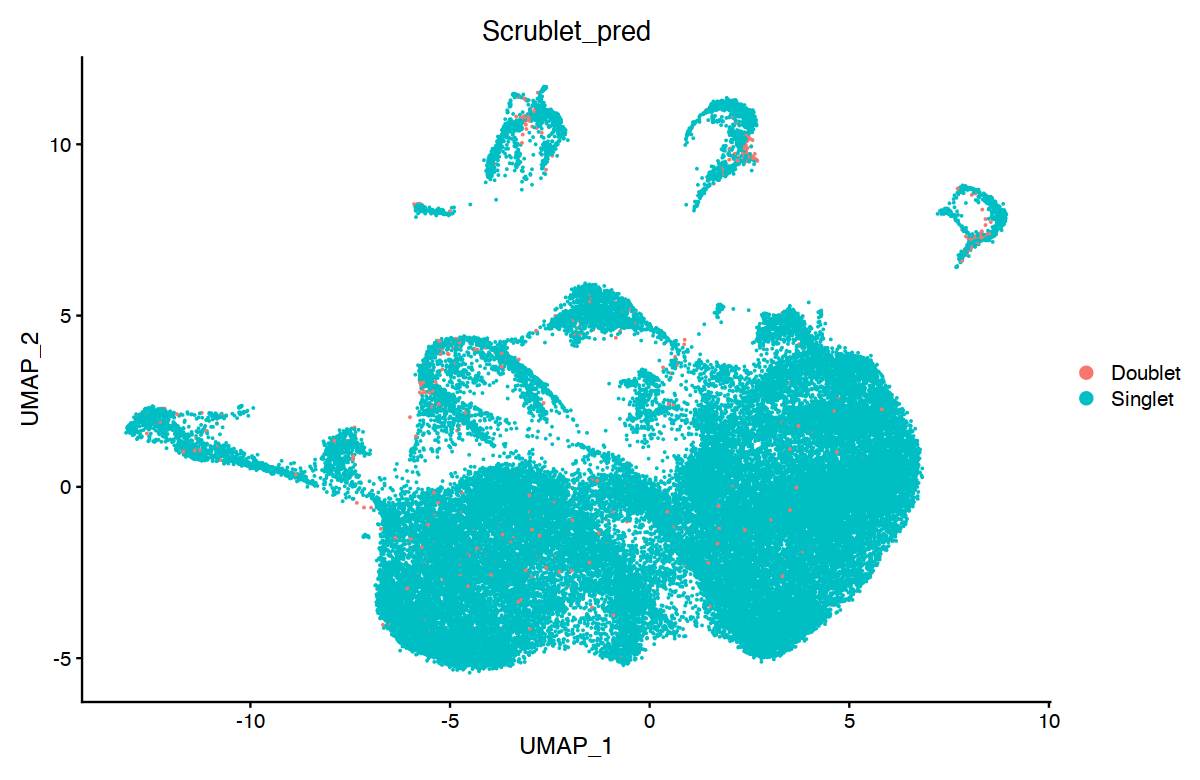

In [8]:
singlet.files <- c("Scrublet/Sham1_CF_singlets.txt",
                   "Scrublet/Sham3_CF_singlets.txt",
                   "Scrublet/Sham4_CF_singlets.txt",
                   "Scrublet/MI1_aCF_singlets.txt",
                   "Scrublet/MI2_aCF_singlets.txt",
                   "Scrublet/MI3_aCF_singlets.txt")

all.singlets <- c()
for (this.file in singlet.files) {
  singlets <- readLines(this.file)
  all.singlets <- append(all.singlets, singlets)
}
print(paste("Predicted singlets from Scrublet:", length(all.singlets)))
print(paste("Overlap with filtered data:", length(intersect(colnames(genes.seurat), all.singlets))))

scrublet.doublet <- ifelse(colnames(genes.seurat) %in% all.singlets, "Singlet", "Doublet")
genes.seurat@meta.data$Scrublet_pred <- scrublet.doublet

options(repr.plot.width=10, repr.plot.height=6.5)
DimPlot(genes.seurat, group.by = "Scrublet_pred")

# Integration

There appears to be a batch effect with the IR_4 sample. Will use the Seurat integration pipeline for the experiments. 

[1] 19266 50987

[1] 6

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 25732 anchors

Filtering anchors

	Retained 10878 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 15699 anchors

Filtering anchors

	Retained 9500 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 16998 anchors

Filtering anchors

	Retained 9296 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 20217 anchors

Filtering anchors

	Retained 2499 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 21147 anchors

Filtering anchors

	Retained 3308 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 13878 anchors

Filtering anchors

	Retained 2551 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 18185 anchors

Filtering anchors

	Retained

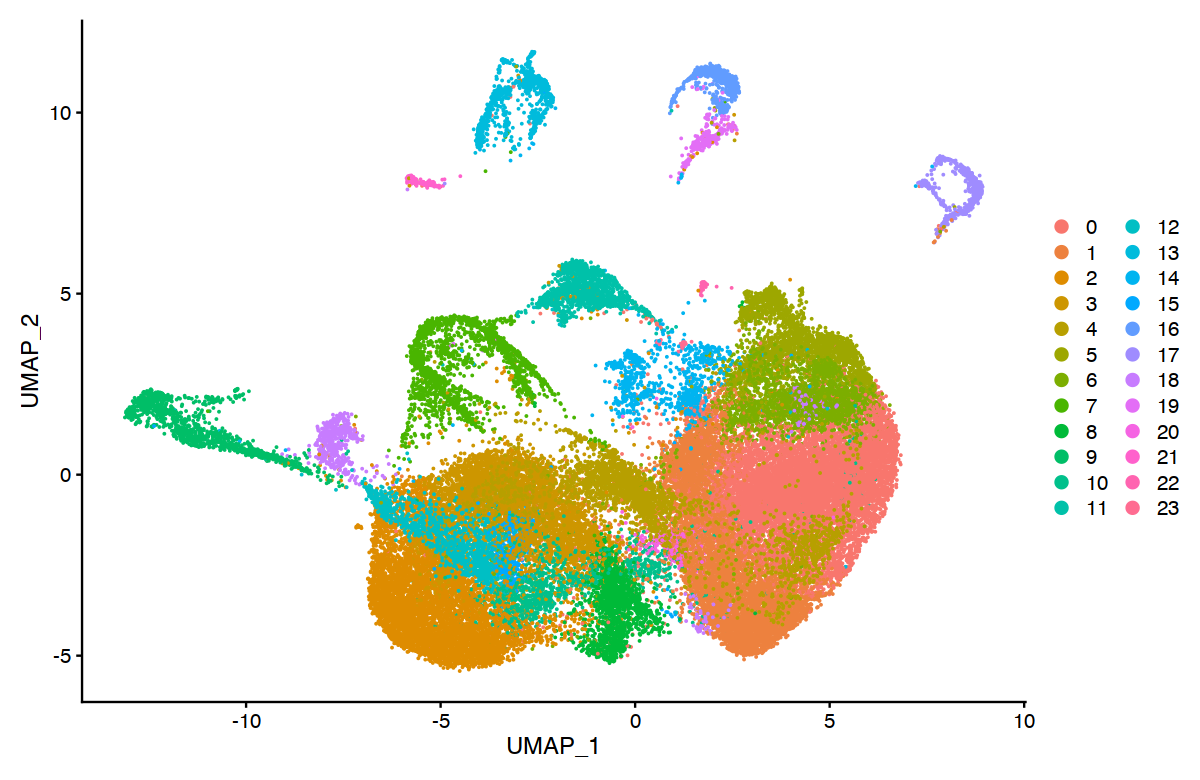

In [9]:
genes.seurat <- subset(genes.seurat, Scrublet_pred == "Singlet")
dim(genes.seurat)
DimPlot(genes.seurat)

dataset.list <- Seurat::SplitObject(genes.seurat, split.by = "Experiment")
length(dataset.list)

remove(genes.seurat)

# normalize and identify variable features for each dataset independently
dataset.list <- lapply(X = dataset.list, FUN = function(x) {
  x <- NormalizeData(x)
  x <- FindVariableFeatures(x, nfeatures = 3000)
  return(x)
})


int.features <- SelectIntegrationFeatures(object.list = dataset.list, nfeatures = 3000)

heart.anchors <- FindIntegrationAnchors(object.list = dataset.list, 
                                        anchor.features = int.features,
                                        normalization.method = "LogNormalize")
remove(dataset.list)
heart.combined <- IntegrateData(anchorset = heart.anchors)
remove(heart.anchors)

In [10]:
DefaultAssay(heart.combined) <- "integrated"

heart.combined <- ScaleData(heart.combined)
heart.combined <- RunPCA(heart.combined, assay = "integrated")

## Clustering
heart.combined <- FindNeighbors(heart.combined, k.param = 25, dims = 1:25)
heart.combined <- FindClusters(heart.combined, resolution = c(0.4, 0.5, 0.6))

### UMAP/t-SNE analysis
heart.combined <- RunUMAP(heart.combined, 
                        n.neighbors = 30, 
                        dims = 1:30,
                        min.dist = 0.3,
                        seed.use = 25)

Centering and scaling data matrix

PC_ 1 
Positive:  Gsn, Gstm1, Clec3b, Htra3, Cfh, Dpep1, Apoe, Selenop, Junb, Tnxb 
	   Mgst1, Rarres2, Fth1, Sparcl1, Fbln1, Ier2, Abca8a, Dusp1, Lpl, Smoc2 
	   Glul, Selenbp1, C3, Pi16, Plpp3, Fos, G0s2, Crispld2, Nr4a1, C1s1 
Negative:  Cdk1, Actn1, Tpx2, Fn1, Spc24, Birc5, Pclaf, Ddah1, Top2a, Ccna2 
	   Cdca8, Ccnb1, Palld, Pbk, Postn, Cthrc1, Stmn1, Tagln, Tk1, Cks2 
	   Lox, Cdca3, Spc25, Racgap1, Mki67, Hmmr, Nuf2, Cenpe, Kif23, Plk1 
PC_ 2 
Positive:  Pbk, Pclaf, Top2a, Ccna2, Tpx2, Spc25, Birc5, Prc1, Ube2c, Stmn1 
	   Cdca8, Nusap1, Plk1, Ccnb1, Cenpf, Kif23, Mki67, Tk1, Cdca3, Hmmr 
	   Ccnb2, Cdc20, Asf1b, Kif22, Aurka, Spc24, Ckap2l, Tacc3, Cdkn3, Aurkb 
Negative:  Col1a1, Cthrc1, Col1a2, Lox, Ddah1, Postn, Fn1, Col3a1, Col5a2, Ltbp2 
	   Mfap4, Aspn, P4ha3, Palld, Pdgfrl, Ogn, Sfrp1, Sparc, Sfrp2, Col8a1 
	   Ptn, Ccn4, Rflnb, Csrp2, Gxylt2, Col8a2, Col5a1, Thbs2, Col14a1, Nedd9 
PC_ 3 
Positive:  Gsn, Pi16, Lum, Mfap5, Pmp22, Smoc2, C

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 50987
Number of edges: 1919928

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9134
Number of communities: 18
Elapsed time: 12 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 50987
Number of edges: 1919928

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9049
Number of communities: 21
Elapsed time: 11 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 50987
Number of edges: 1919928

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8969
Number of communities: 23
Elapsed time: 11 seconds


19:13:09 UMAP embedding parameters a = 0.9922 b = 1.112

19:13:09 Read 50987 rows and found 30 numeric columns

19:13:09 Using Annoy for neighbor search, n_neighbors = 30

19:13:09 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:13:12 Writing NN index file to temp file /var/folders/2p/fzztw4ls58lcjyzm918ky5900000gn/T//RtmpD03Lzy/filecd2c7e57f27d

19:13:12 Searching Annoy index using 1 thread, search_k = 3000

19:13:24 Annoy recall = 100%

19:13:24 Commencing smooth kNN distance calibration using 1 thread

19:13:26 Initializing from normalized Laplacian + noise

19:13:33 Commencing optimization for 200 epochs, with 2300010 positive edges

19:13:58 Optimization finished



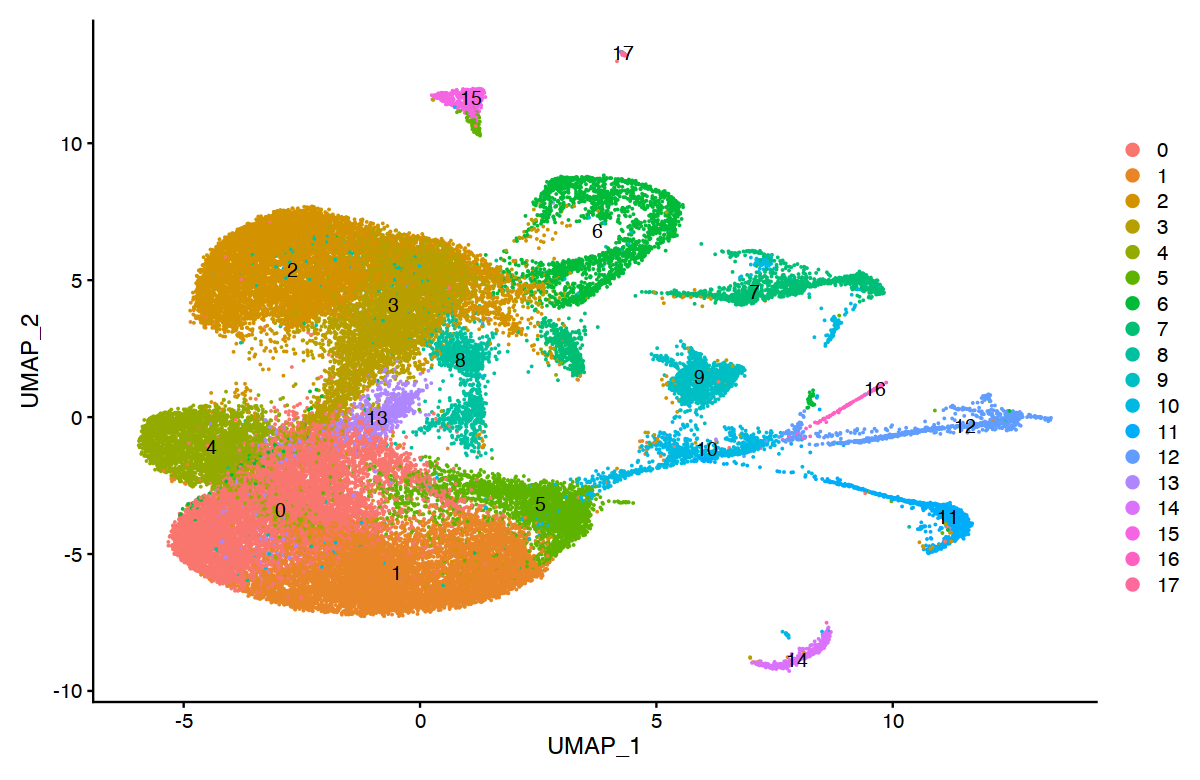

In [11]:
options(repr.plot.width=10, repr.plot.height=6.5)
Idents(heart.combined) <- heart.combined@meta.data$integrated_snn_res.0.4

DimPlot(heart.combined, reduction = "umap", label = TRUE)

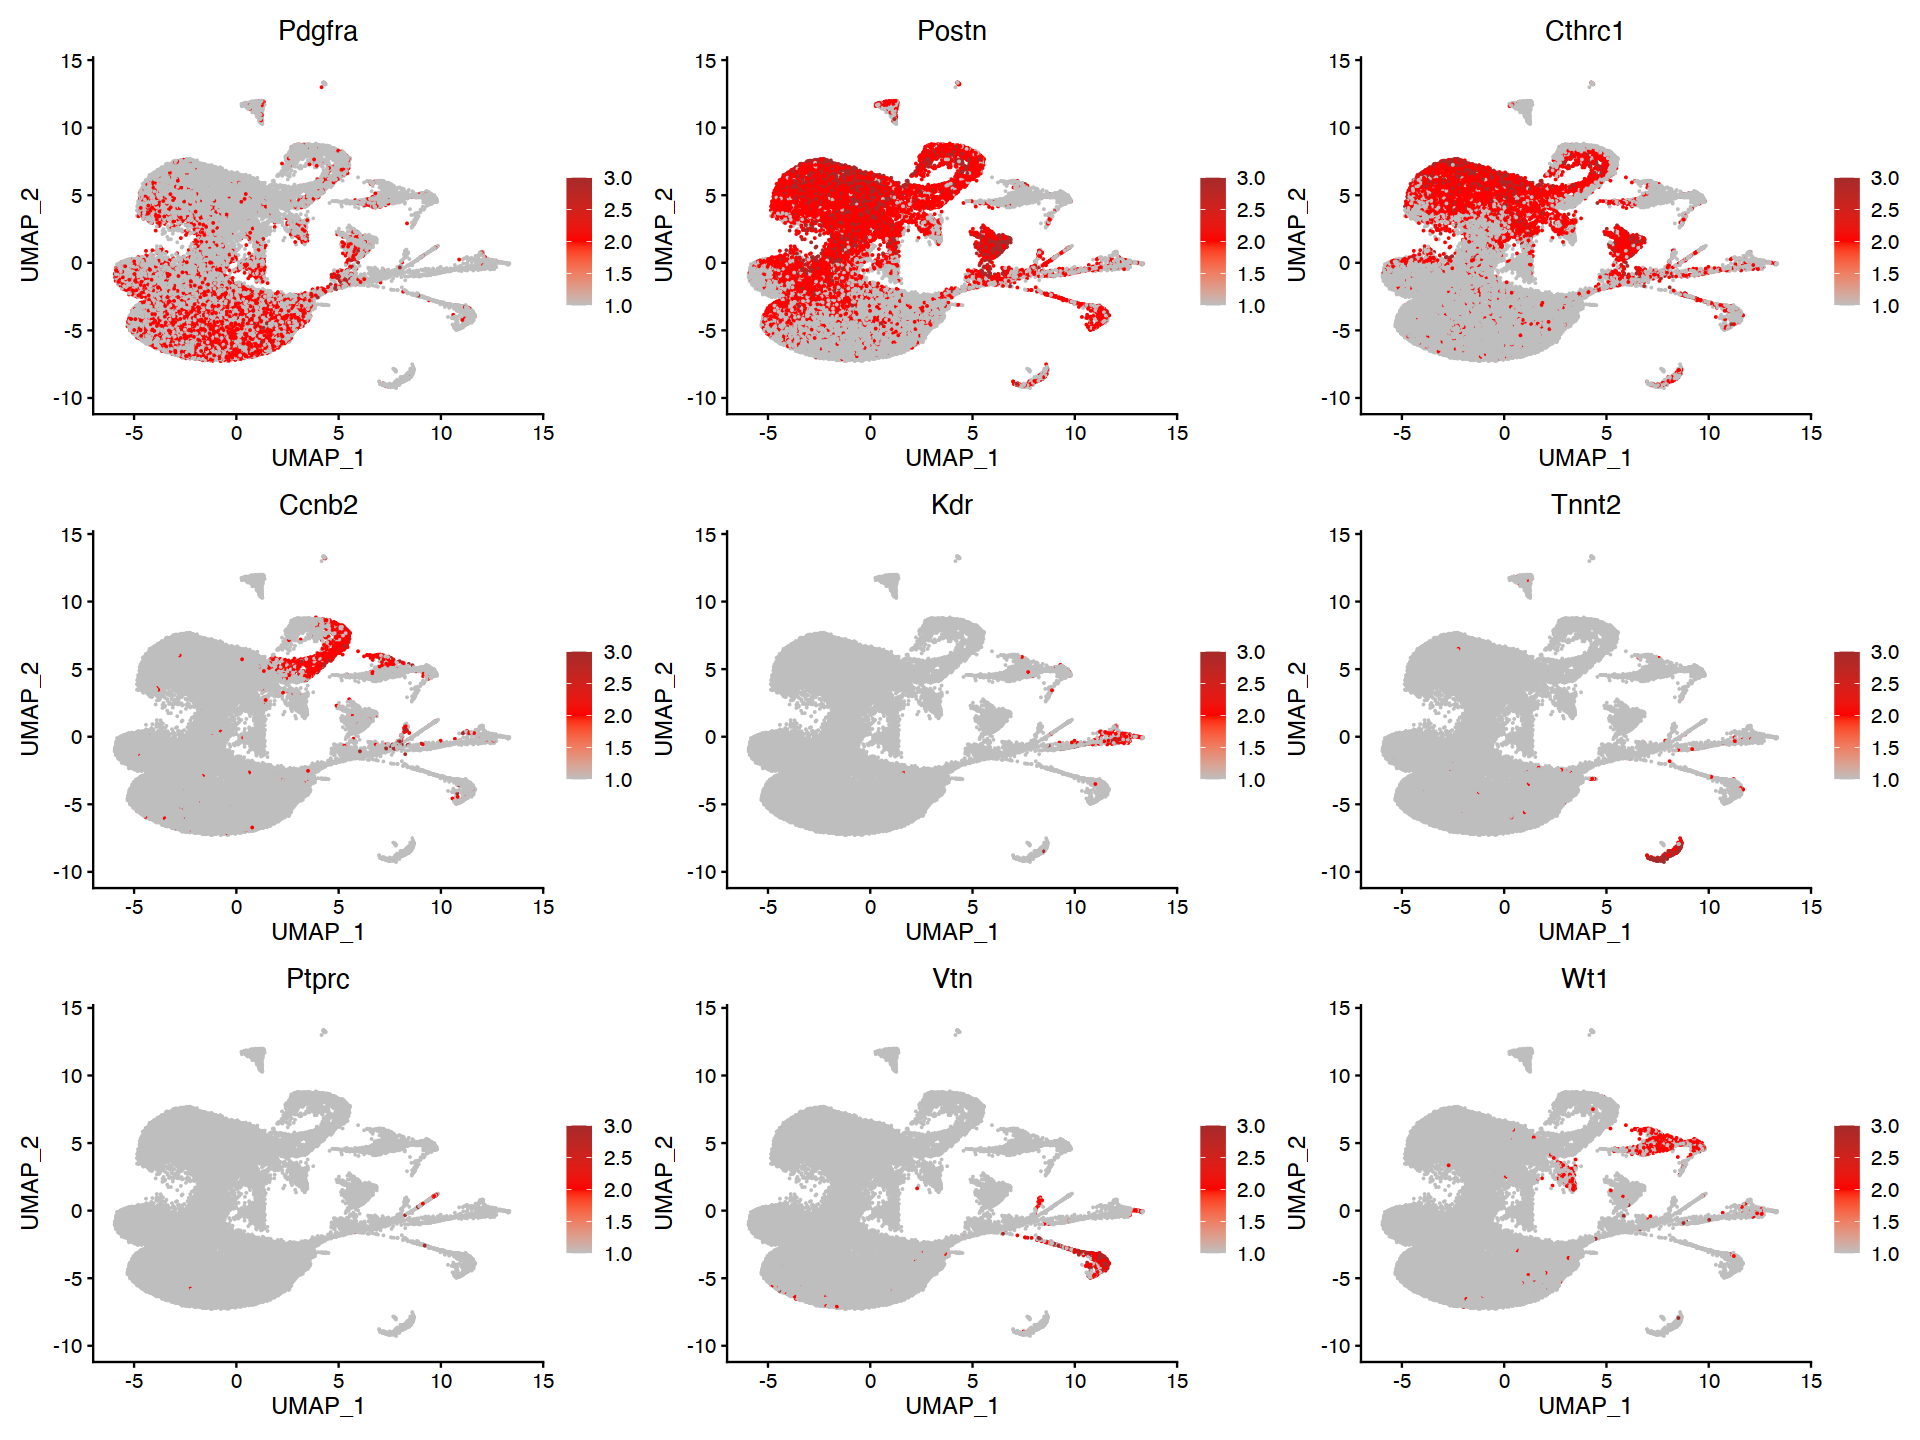

In [12]:
DefaultAssay(heart.combined) <- "RNA"

options(repr.plot.width=16, repr.plot.height=12)
FeaturePlot(heart.combined, c("Pdgfra", "Postn", "Cthrc1", "Ccnb2", "Kdr","Tnnt2", "Ptprc", "Vtn", "Wt1"),
cols = c("grey", "red", "brown"))

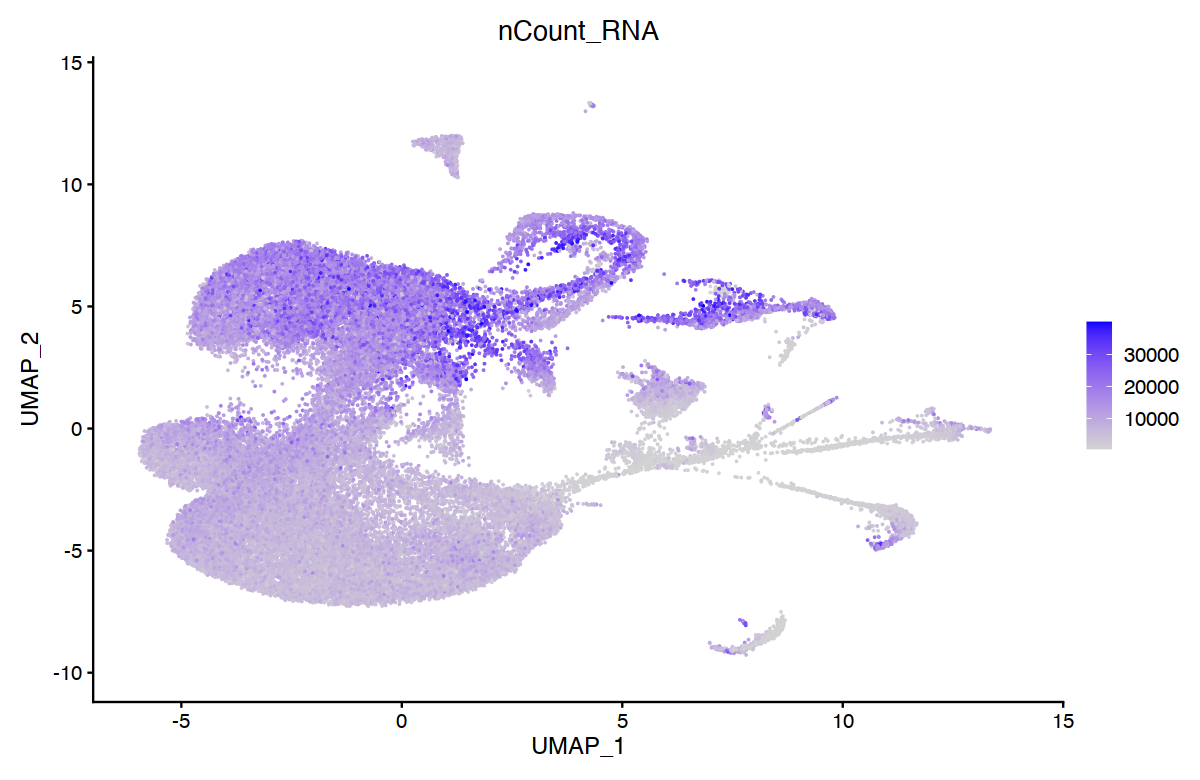

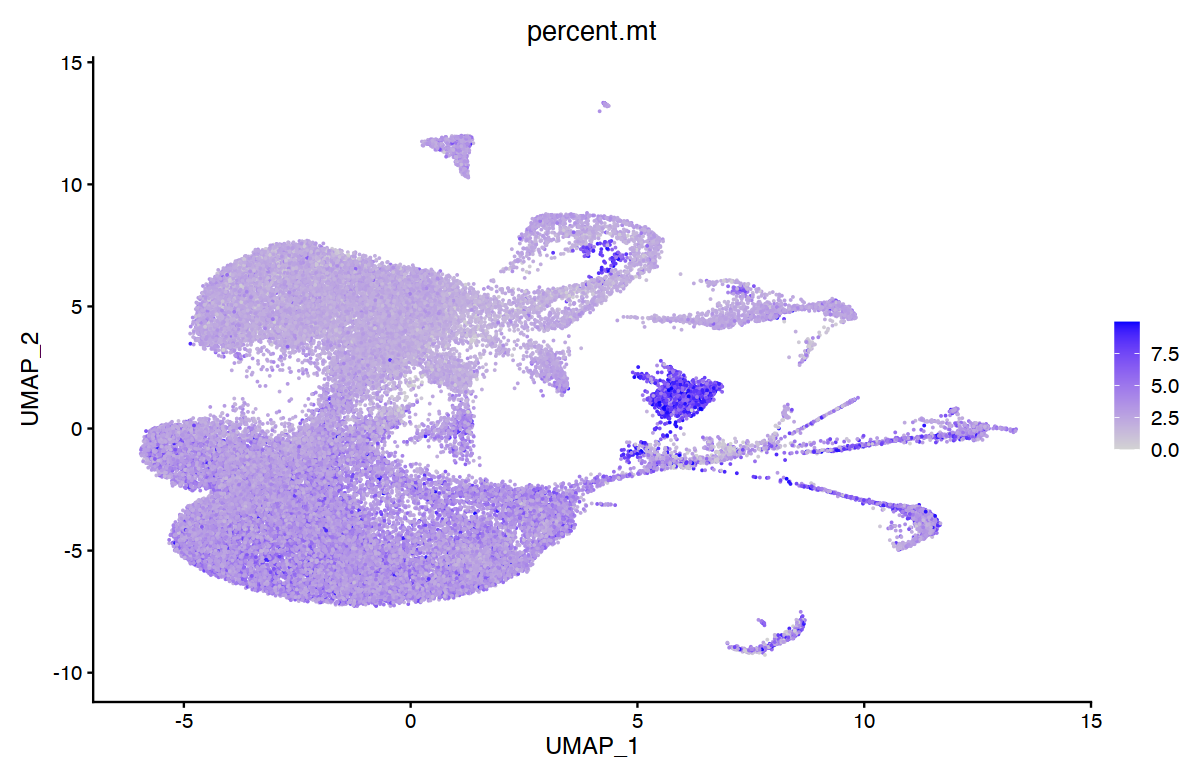

In [13]:
options(repr.plot.width=10, repr.plot.height=6.5)
FeaturePlot( heart.combined, "nCount_RNA" )
FeaturePlot( heart.combined, "percent.mt" )

# Select fibroblasts

[1] 19266 42996

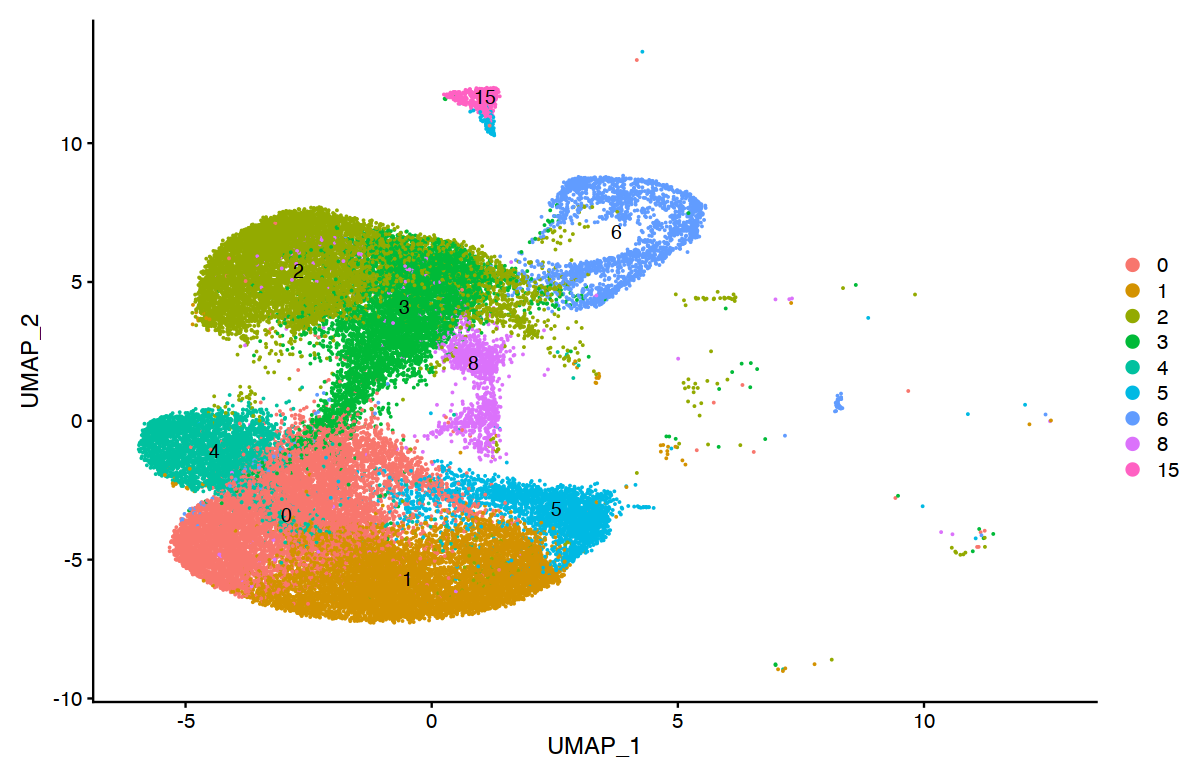

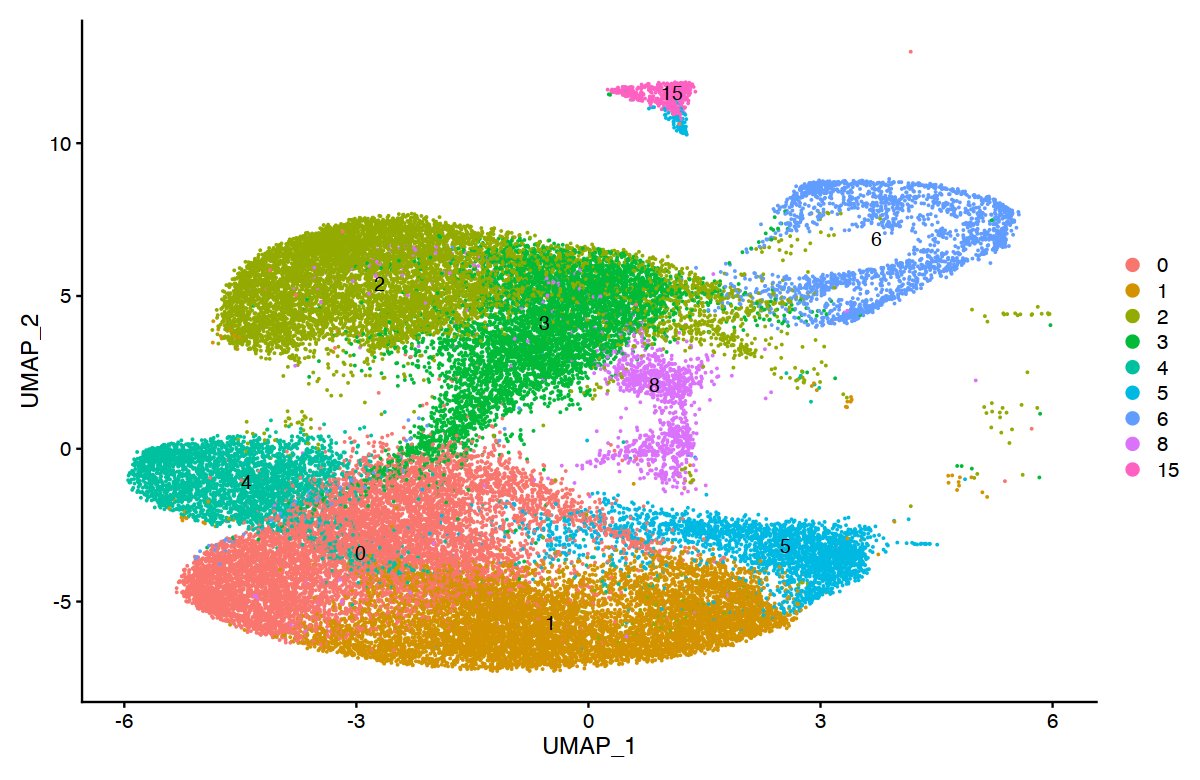

In [14]:
fibro.clusters <- c("0", "1", "2", "3", "4", "5", "6", "8", "15")

fibroblasts.seurat <- subset( heart.combined, idents = fibro.clusters )
dim(fibroblasts.seurat)

DimPlot(fibroblasts.seurat, reduction = "umap", label = TRUE)

fibroblasts.seurat <- subset(fibroblasts.seurat, UMAP_2 < 13)
fibroblasts.seurat <- subset(fibroblasts.seurat, UMAP_1 < 6)

DimPlot(fibroblasts.seurat, reduction = "umap", label = TRUE)

fibroblasts.seurat$ClusterIDs <- plyr::mapvalues(Idents(fibroblasts.seurat),
                                                 from = c("0", "1", "2", "3", "4", "5", "6", "8", "15"),
                                                 to = c("F-Act", "F-SL", "MYO-1", "MYO-2", "F-SH", 
                                                        "F-Trans", "F-Cyc", "F-IFNS", "F-WntX"))
Idents(fibroblasts.seurat) <- fibroblasts.seurat$ClusterIDs


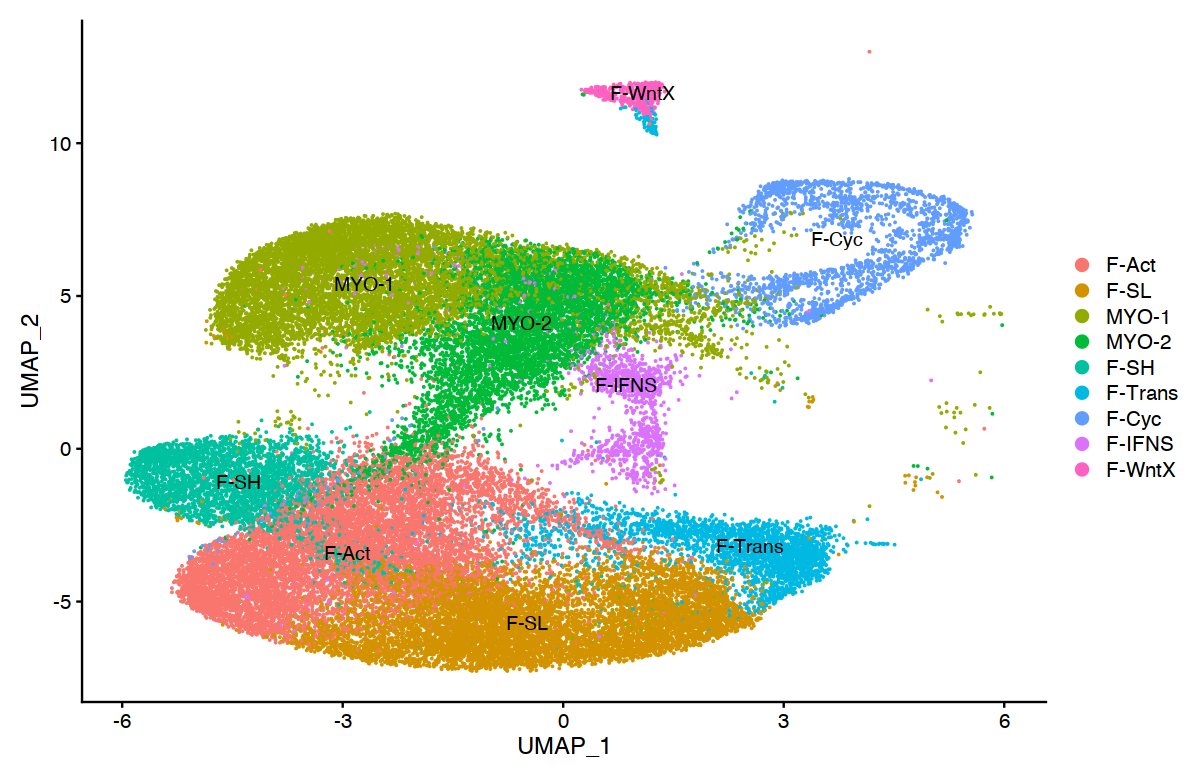

In [15]:
options(repr.plot.width=10, repr.plot.height=6.5)
DimPlot(fibroblasts.seurat, reduction = "umap", label = TRUE)

# Session information

In [16]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRlapack.dylib

locale:
[1] en_AU.UTF-8/en_AU.UTF-8/en_AU.UTF-8/C/en_AU.UTF-8/en_AU.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] Matrix_1.3-4       dplyr_1.0.7        plyr_1.8.6         SeuratObject_4.0.2
[5] Seurat_4.0.3       ggplot2_3.3.5     

loaded via a namespace (and not attached):
  [1] nlme_3.1-152          spatstat.sparse_2.0-0 matrixStats_0.60.0   
  [4] RcppAnnoy_0.0.19      RColorBrewer_1.1-2    httr_1.4.2           
  [7] repr_1.1.3            sctransform_0.3.2     tools_4.1.0          
 [10] utf8_1.2.2            R6_2.5.0              irlba_2.3.3          
 [13] rpart_4.1-15          KernSmooth_2.23-20 